In [1]:
import os
from pathlib import Path

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("ggplot")

from coffea.nanoevents import NanoEventsFactory, PHYSLITESchema
from coffea import dataset_tools

import time
import warnings

warnings.filterwarnings("ignore")

from dask.distributed import LocalCluster, Client, progress, performance_report

# local: single thread, single worker
cluster = LocalCluster(n_workers=1, processes=False, threads_per_worker=1)
client = Client(cluster)

# for UChicago
# client = Client("tcp://dask-alheld-a76c9434-b.af-jupyter:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

awkward: 2.6.2
dask-awkward: 2024.3.0
uproot: 5.3.2
hist: 2.7.2
coffea: 2024.3.0


### interactive coffea for debugging

In [2]:
fname = "/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1"
treename = "CollectionTree"
events = NanoEventsFactory.from_root({fname: treename}, schemaclass=PHYSLITESchema).events()

### distributed coffea

In [3]:
def materialize_branches(events):
    # track number of events
    num_events = ak.num(events, axis=0)

    # this will read around 25% of data files
    # materialize branches, just derive integers from them that will be aggregated to avoid memory issues
    _counter = 0
    _counter += ak.count_nonzero(events.Jets.pt)
    _counter += ak.count_nonzero(events.Jets.eta)
    _counter += ak.count_nonzero(events.Jets.phi)
    _counter += ak.count_nonzero(events.Jets.m)
    _counter += ak.count_nonzero(events.Electrons.pt)
    _counter += ak.count_nonzero(events.Electrons.eta)
    _counter += ak.count_nonzero(events.Electrons.phi)
    _counter += ak.count_nonzero(events.Electrons.m)
    _counter += ak.count_nonzero(events.Muons.pt)
    _counter += ak.count_nonzero(events.Muons.eta)
    _counter += ak.count_nonzero(events.Muons.phi)
    _counter += ak.count_nonzero(events.Jets.EnergyPerSampling)
    _counter += ak.count_nonzero(events.Jets.SumPtTrkPt500)
    _counter += ak.count_nonzero(events.Jets.TrackWidthPt1000)
    _counter += ak.count_nonzero(events.PrimaryVertices.z)
    _counter += ak.count_nonzero(events.PrimaryVertices.x)
    _counter += ak.count_nonzero(events.PrimaryVertices.y)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt500)
    _counter += ak.count_nonzero(events.Jets.NumTrkPt1000)
    _counter += ak.count_nonzero(events.Jets.SumPtChargedPFOPt500)
    _counter += ak.count_nonzero(events.Jets.Timing)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_eta)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_eta)
    _counter += ak.count_nonzero(events.Jets.DetectorEta)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_phi)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_phi)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_m)
    _counter += ak.count_nonzero(events.Jets.JetConstitScaleMomentum_pt)
    _counter += ak.count_nonzero(events.Jets.EMFrac)
    _counter += ak.count_nonzero(events.Jets.Width)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_m)
    _counter += ak.count_nonzero(events.Jets.ActiveArea4vec_pt)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksWidth)
    _counter += ak.count_nonzero(events.Jets.PSFrac)
    _counter += ak.count_nonzero(events.Jets.JVFCorr)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_TracksC1)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_fJvt)
    _counter += ak.count_nonzero(events.Jets.DFCommonJets_QGTagger_NTracks)
    _counter += ak.count_nonzero(events.Jets.GhostMuonSegmentCount)
    _counter += ak.count_nonzero(events.Muons.muonSegmentLinks['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.extrapolatedMuonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.inDetTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.muonSpectrometerTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.momentumBalanceSignificance)
    _counter += ak.count_nonzero(events.Muons.topoetcone20_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.scatteringCurvatureSignificance)
    _counter += ak.count_nonzero(events.Muons.scatteringNeighbourSignificance)
    _counter += ak.count_nonzero(events.Muons.neflowisol20_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.topoetcone20)
    _counter += ak.count_nonzero(events.Muons.topoetcone30)
    _counter += ak.count_nonzero(events.Muons.topoetcone40)
    _counter += ak.count_nonzero(events.Muons.neflowisol20)
    _counter += ak.count_nonzero(events.Muons.segmentDeltaEta)
    _counter += ak.count_nonzero(events.Muons.DFCommonJetDr)
    _counter += ak.count_nonzero(events.Muons.combinedTrackParticleLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.InnerDetectorPt)
    _counter += ak.count_nonzero(events.Muons.MuonSpectrometerPt)
    _counter += ak.count_nonzero(events.Muons.clusterLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.spectrometerFieldIntegral)
    _counter += ak.count_nonzero(events.Electrons.ambiguityLink['m_persIndex'])
    _counter += ak.count_nonzero(events.Muons.EnergyLoss)
    _counter += ak.count_nonzero(events.Jets.NNJvtPass)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20_CloseByCorr)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20ptCorrection)
    _counter += ak.count_nonzero(events.Electrons.topoetcone20)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr)
    _counter += ak.count_nonzero(events.Electrons.DFCommonElectronsECIDSResult)
    _counter += ak.count_nonzero(events.Electrons.neflowisol20)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500)
    _counter += ak.count_nonzero(events.Muons.ptcone40)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000)
    _counter += ak.count_nonzero(events.Muons.ptvarcone40)
    _counter += ak.count_nonzero(events.Electrons.f1)
    _counter += ak.count_nonzero(events.Muons.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500)
    _counter += ak.count_nonzero(events.PrimaryVertices.vertexType)
    _counter += ak.count_nonzero(events.Muons.ptvarcone30)
    _counter += ak.count_nonzero(events.Muons.ptcone30)
    _counter += ak.count_nonzero(events.Muons.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000)
    _counter += ak.count_nonzero(events.Electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500)
    _counter += ak.count_nonzero(events.Muons.CaloLRLikelihood)

    return {"nevts": num_events, "_counter": _counter}

just run over a local data file here as an example

In [4]:
fileset = {"data": {"files": {fname: treename}}}
fileset

{'data': {'files': {'/data/alheld/200gbps-atlas/data18_13TeV.periodAllYear.physics_Main.PhysCont.DAOD_PHYSLITE.grp18_v01_p6026/DAOD_PHYSLITE.37021624._000036.pool.root.1': 'CollectionTree'}}}

In [5]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=1_000_000)

CPU times: user 1.17 s, sys: 25.1 ms, total: 1.2 s
Wall time: 1.18 s


In [6]:
BRANCH_LIST = [
    "AnalysisJetsAuxDyn.pt",
    "AnalysisJetsAuxDyn.eta",
    "AnalysisJetsAuxDyn.phi",
    "AnalysisJetsAuxDyn.m",
    "AnalysisElectronsAuxDyn.pt",
    "AnalysisElectronsAuxDyn.eta",
    "AnalysisElectronsAuxDyn.phi",
    "AnalysisElectronsAuxDyn.m",
    "AnalysisMuonsAuxDyn.pt",
    "AnalysisMuonsAuxDyn.eta",
    "AnalysisMuonsAuxDyn.phi",
    "AnalysisJetsAuxDyn.EnergyPerSampling",
    "AnalysisJetsAuxDyn.SumPtTrkPt500",
    "AnalysisJetsAuxDyn.TrackWidthPt1000",
    "PrimaryVerticesAuxDyn.z",
    "PrimaryVerticesAuxDyn.x",
    "PrimaryVerticesAuxDyn.y",
    "AnalysisJetsAuxDyn.NumTrkPt500",
    "AnalysisJetsAuxDyn.NumTrkPt1000",
    "AnalysisJetsAuxDyn.SumPtChargedPFOPt500",
    "AnalysisJetsAuxDyn.Timing",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_eta",
    "AnalysisJetsAuxDyn.ActiveArea4vec_eta",
    "AnalysisJetsAuxDyn.DetectorEta",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_phi",
    "AnalysisJetsAuxDyn.ActiveArea4vec_phi",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_m",
    "AnalysisJetsAuxDyn.JetConstitScaleMomentum_pt",
    "AnalysisJetsAuxDyn.EMFrac",
    "AnalysisJetsAuxDyn.Width",
    "AnalysisJetsAuxDyn.ActiveArea4vec_m",
    "AnalysisJetsAuxDyn.ActiveArea4vec_pt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksWidth",
    "AnalysisJetsAuxDyn.PSFrac",
    "AnalysisJetsAuxDyn.JVFCorr",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_TracksC1",
    "AnalysisJetsAuxDyn.DFCommonJets_fJvt",
    "AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks",
    "AnalysisJetsAuxDyn.GhostMuonSegmentCount",
    "AnalysisMuonsAuxDyn.muonSegmentLinks",
    "AnalysisMuonsAuxDyn.msOnlyExtrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.extrapolatedMuonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.inDetTrackParticleLink",
    "AnalysisMuonsAuxDyn.muonSpectrometerTrackParticleLink",
    "AnalysisMuonsAuxDyn.momentumBalanceSignificance",
    "AnalysisMuonsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisMuonsAuxDyn.scatteringCurvatureSignificance",
    "AnalysisMuonsAuxDyn.scatteringNeighbourSignificance",
    "AnalysisMuonsAuxDyn.neflowisol20_CloseByCorr",
    "AnalysisMuonsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.topoetcone30",
    "AnalysisMuonsAuxDyn.topoetcone40",
    "AnalysisMuonsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.segmentDeltaEta",
    "AnalysisMuonsAuxDyn.DFCommonJetDr",
    "AnalysisMuonsAuxDyn.combinedTrackParticleLink",
    "AnalysisMuonsAuxDyn.InnerDetectorPt",
    "AnalysisMuonsAuxDyn.MuonSpectrometerPt",
    "AnalysisMuonsAuxDyn.clusterLink",
    "AnalysisMuonsAuxDyn.spectrometerFieldIntegral",
    "AnalysisElectronsAuxDyn.ambiguityLink",
    "AnalysisMuonsAuxDyn.EnergyLoss",
    "AnalysisJetsAuxDyn.NNJvtPass",
    "AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr",
    "AnalysisElectronsAuxDyn.topoetcone20ptCorrection",
    "AnalysisElectronsAuxDyn.topoetcone20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500_CloseByCorr",
    "AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult",
    "AnalysisElectronsAuxDyn.neflowisol20",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt500",
    "AnalysisMuonsAuxDyn.ptcone40",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000_CloseByCorr",
    "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000",
    "AnalysisMuonsAuxDyn.ptvarcone40",
    "AnalysisElectronsAuxDyn.f1",
    "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt500",
    "PrimaryVerticesAuxDyn.vertexType",
    "AnalysisMuonsAuxDyn.ptvarcone30",
    "AnalysisMuonsAuxDyn.ptcone30",
    "AnalysisMuonsAuxDyn.ptcone20_Nonprompt_All_MaxWeightTTVA_pt1000",
    "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500",
    "AnalysisMuonsAuxDyn.CaloLRLikelihood"
]

filter_name = lambda name: name in BRANCH_LIST

In [7]:
%%time
# create the task graph
# filter_name seems to not do anything here in terms of performance
tasks = dataset_tools.apply_to_fileset(materialize_branches,
                                       samples,
                                       uproot_options={"allow_read_errors_with_report": True, "filter_name": filter_name},
                                       schemaclass=PHYSLITESchema)

CPU times: user 2.15 s, sys: 34.3 ms, total: 2.18 s
Wall time: 2.16 s


execute task graph

In [8]:
%%time
# execute
t0 = time.perf_counter()
with performance_report(filename="dask-report.html"):
    ((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple
t1 = time.perf_counter()

print(f"total time spent in uproot reading data: {ak.sum([v['duration'] for v in report.values()]):.2f} s")
print(f"wall time: {t1-t0:.2f}s")

total time spent in uproot reading data: 65.92 s
wall time: 69.24s
CPU times: user 30.3 s, sys: 40.3 s, total: 1min 10s
Wall time: 1min 9s


In [9]:
print(f"output: {out}")

print("\nperformance metrics:")

event_rate = out["data"]["nevts"] / (t1-t0)
print(f" - event rate: {event_rate / 1_000:.2f} kHz")

# need uproot>=5.3.2 to get these useful performance stats
read_MB = sum(report['data']['performance_counters']['num_requested_bytes']) / 1_000**2
rate_Mbs = read_MB / (t1-t0)
print(f" - read {read_MB:.2f} MB in {t1-t0:.2f} s -> {rate_Mbs:.2f} MBps (need to scale by x{200/8/rate_Mbs*1000:.0f} to reach 200 Gbps)")

output: {'data': {'nevts': 127482, '_counter': 97995532}}

performance metrics:
 - event rate: 1.84 kHz
 - read 409.56 MB in 69.24 s -> 5.92 MBps (need to scale by x4226 to reach 200 Gbps)


In [10]:
# sanity check that the right colums are being touched
dak.report_necessary_columns(tasks)

{'from-uproot-a425e4500d963f22bf8285371d571b32': frozenset({'AnalysisElectronsAuxDyn.DFCommonElectronsECIDSResult',
            'AnalysisElectronsAuxDyn.ambiguityLink',
            'AnalysisElectronsAuxDyn.eta',
            'AnalysisElectronsAuxDyn.f1',
            'AnalysisElectronsAuxDyn.m',
            'AnalysisElectronsAuxDyn.neflowisol20',
            'AnalysisElectronsAuxDyn.phi',
            'AnalysisElectronsAuxDyn.pt',
            'AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
            'AnalysisElectronsAuxDyn.topoetcone20',
            'AnalysisElectronsAuxDyn.topoetcone20_CloseByCorr',
            'AnalysisElectronsAuxDyn.topoetcone20ptCorrection',
            'AnalysisJetsAuxDyn.ActiveArea4vec_eta',
            'AnalysisJetsAuxDyn.ActiveArea4vec_m',
            'AnalysisJetsAuxDyn.ActiveArea4vec_phi',
            'AnalysisJetsAuxDyn.ActiveArea4vec_pt',
            'AnalysisJetsAuxDyn.DFCommonJets_QGTagger_NTracks',
            'Analysis

## sanity check: read those columns without any Dask / coffea, compare footprint

In [11]:
branches_touched = list(list(dak.report_necessary_columns(tasks).values())[0])

t = uproot.open({fname: "CollectionTree"})

initial_size_in_MB = t.file.source.num_requested_bytes/1000**2  # non-zero at the start (some metadata read)

t.arrays(branches_touched)

new_size_in_MB = t.file.source.num_requested_bytes/1000**2
print(initial_size_in_MB, new_size_in_MB)

2.260006 283.192324


This should match the numbers reported above through coffea, but it currently does not! This needs to be understood.

## rest of the notebook: non-Dask / non-coffea local tests for performance comparisons

In [12]:
# time each branch individually, compare to size of the branch, ensure no extreme outliers are present
for i in range(len(BRANCH_LIST)):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f[BRANCH_LIST[i]].array()
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        time_ms = (t1-t0)*1000
        size_MB = (new_size_in_MB-initial_metadata_in_MB)
        print(f"{BRANCH_LIST[i]:<80}: {time_ms:4.0f} ms\t\t{size_MB:>5.2f} MB\t\t{size_MB / time_ms * 1000:>5.1f} MB/s")

AnalysisJetsAuxDyn.pt                                                           :  249 ms		 5.03 MB		 20.2 MB/s
AnalysisJetsAuxDyn.eta                                                          :  251 ms		 5.25 MB		 20.9 MB/s
AnalysisJetsAuxDyn.phi                                                          :  248 ms		 5.24 MB		 21.1 MB/s
AnalysisJetsAuxDyn.m                                                            :  248 ms		 5.05 MB		 20.4 MB/s
AnalysisElectronsAuxDyn.pt                                                      :  367 ms		 0.67 MB		  1.8 MB/s
AnalysisElectronsAuxDyn.eta                                                     :  371 ms		 0.68 MB		  1.8 MB/s
AnalysisElectronsAuxDyn.phi                                                     :  372 ms		 0.68 MB		  1.8 MB/s
AnalysisElectronsAuxDyn.m                                                       :  373 ms		 0.43 MB		  1.2 MB/s
AnalysisMuonsAuxDyn.pt                                                          :  377 ms		 0.74 MB		  2

In [13]:
file_size = os.path.getsize(fname) / 1000**2  # all sizes in MB

time_per_fraction_read = {}
for i in range(len(BRANCH_LIST)//12+1):
    with uproot.open({fname: treename}, filter_name=filter_name) as f:  # re-open every time for accurate tracking of data read
        branches = BRANCH_LIST[0:(i+1)*12]
        print(f"reading {len(branches)} branch(es)")
        initial_metadata_in_MB = f.file.source.num_requested_bytes/1000**2
        t0 = time.perf_counter()
        f.arrays(branches)
        t1 = time.perf_counter()
        new_size_in_MB = f.file.source.num_requested_bytes/1000**2
        fraction_read = (new_size_in_MB - initial_metadata_in_MB) / file_size
        time_per_fraction_read[fraction_read] = t1 - t0
        print(f"  - read {new_size_in_MB - initial_metadata_in_MB:.2f} MB in {t1 - t0:.2f} s")

with uproot.open({fname: treename}) as f:
    nevts = f.num_entries

reading 12 branch(es)
  - read 64.08 MB in 6.76 s
reading 24 branch(es)
  - read 191.08 MB in 19.10 s
reading 36 branch(es)
  - read 245.91 MB in 22.42 s
reading 48 branch(es)
  - read 257.35 MB in 30.04 s
reading 60 branch(es)
  - read 266.31 MB in 35.72 s
reading 72 branch(es)
  - read 274.57 MB in 42.14 s
reading 82 branch(es)
  - read 280.93 MB in 48.16 s


The fraction of the file being depends on the file type and may differ from data, where the derivation of these branches was performed to hit 25%.

In [14]:
for k, v in time_per_fraction_read.items():
    print(f"fraction read: {k:.2%} in {v:.2f} s")

fraction read: 5.70% in 6.76 s
fraction read: 17.01% in 19.10 s
fraction read: 21.89% in 22.42 s
fraction read: 22.91% in 30.04 s
fraction read: 23.70% in 35.72 s
fraction read: 24.44% in 42.14 s
fraction read: 25.01% in 48.16 s


(0.0, 19.676398102626532)

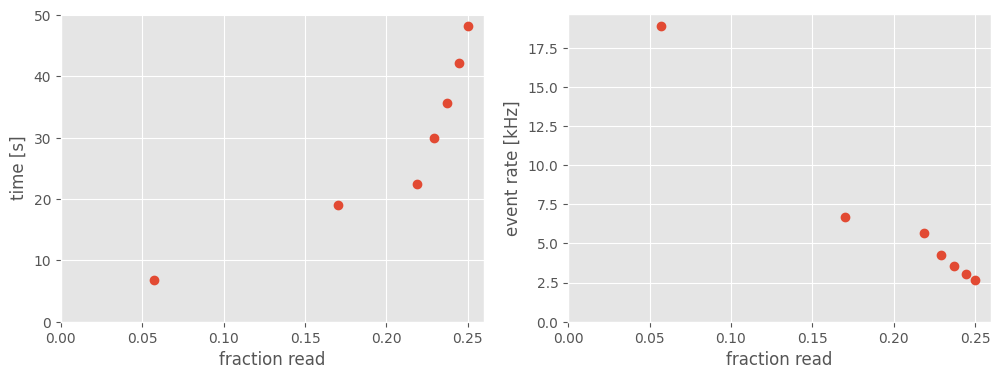

In [15]:
event_rate_in_kHz = nevts / np.fromiter(time_per_fraction_read.values(), np.float32) / 1_000

fig, (ax0, ax1) = plt.subplots(figsize=(12,4), ncols=2)

ax0.plot(time_per_fraction_read.keys(), time_per_fraction_read.values(), "o")
ax0.set_xlabel("fraction read")
ax0.set_ylabel("time [s]")
ax0.set_xlim([0, ax0.get_xlim()[1]])
ax0.set_ylim([0, ax0.get_ylim()[1]])

ax1.plot(time_per_fraction_read.keys(), event_rate_in_kHz, "o")
ax1.set_xlabel("fraction read")
ax1.set_ylabel("event rate [kHz]")
ax1.set_xlim([0, ax1.get_xlim()[1]])
ax1.set_ylim([0, ax1.get_ylim()[1]])

In [16]:
# pure "metadata" (?) part, would be read on every open call
with uproot.open({fname: treename}) as f:
    print(f"{f.file.source.num_requested_bytes/1000**2:.2f} MB")

2.26 MB


(0.0, 89.82277641296386)

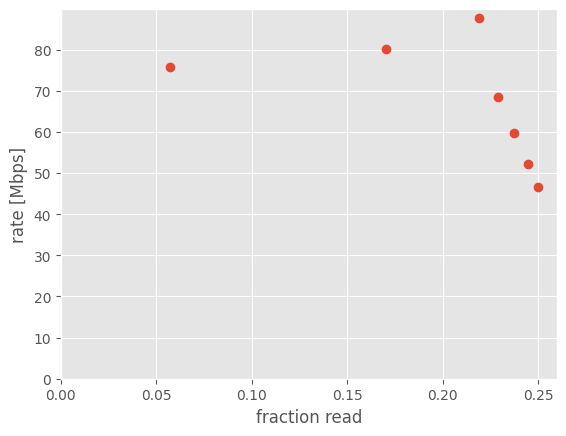

In [17]:
# fraction read * file size (in MB) * 8 (to Mb) / time (in s)
io_in_Mbps = np.fromiter(time_per_fraction_read.keys(), np.float32) * file_size * 8 / np.fromiter(time_per_fraction_read.values(), np.float32)

fig, ax = plt.subplots()

ax.plot(time_per_fraction_read.keys(), io_in_Mbps, "o")
ax.set_xlabel("fraction read")
ax.set_ylabel("rate [Mbps]")
ax.set_xlim([0, ax.get_xlim()[1]])
ax.set_ylim([0, ax.get_ylim()[1]])